# Multiclass classification using a neural network

Here we adopt a 

In [301]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score, train_test_split, KFold

import tensorflow as tf
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2932593983632241170
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3153041817
locality {
  bus_id: 1
  links {
  }
}
incarnation: 844901051005334889
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [302]:
matrix = pd.read_csv('model/1129-fixed-data-matrix-karlgren.csv').set_index('character')

In [303]:
import json
with open('hypothesized_phonetic_series.json', encoding='utf8') as f:
    js = json.load(f)

In [304]:
def getps(char):
    if char in js:
        return js[char]
    else:
        return 0
    
def rowIndex(row):
    return getps(row.name)

matrix['ps'] = matrix.apply(rowIndex, axis=1)

one_hot = pd.get_dummies(matrix['ps'], prefix = 'ps')
dropval = 3
print(one_hot.shape)
one_hot.drop([col for col, val in one_hot.sum().iteritems() if val < dropval], axis=1, inplace=True)
print(one_hot.shape)

matrix = matrix.drop('ps', axis = 1)

matrix = matrix.join(one_hot)
matrix.columns
matrix

(15250, 4097)
(15250, 981)


,mando_onset_b,mando_onset_c,mando_onset_ch,mando_onset_d,mando_onset_f,mando_onset_g,mando_onset_h,mando_onset_j,mando_onset_k,mando_onset_l,...,ps_𢆉,ps_𢆶,ps_𣪠,ps_𤔔,ps_𥁕,ps_𦐇,ps_𦣝,ps_𦣻,ps_𦥑,ps_𧴪
character,,,,,,,,,,,,,,,,,,,,,
㐁,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
㐆,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
㐭,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
㐱,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
㐲,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
㐸,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
㑁,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
㑃,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
㑉,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [305]:
cols = matrix.columns
features_cols = [c for c in cols if 'Karlgren' not in c and 'tone_label' not in c]
labels_cols = [c for c in cols if c not in features_cols]

In [ ]:
X_complete = matrix[features_cols]
Y_complete = matrix[labels_cols]
X_train, X_test, Y_train, Y_test = train_test_split(X_complete, Y_complete, test_size=.3, random_state=0)

In [ ]:
label_categories = [
    'tone_label',
#     'Karlgren_onset',
#     'Karlgren_nucleus',
#     'Karlgren_coda'
]

# label_categories = [
#     'tone_label',
#     'Karlgren_onset',
#     'Karlgren_nucleus',
#     'Karlgren_coda'
# ]


In [ ]:
Y_train.head()

In [ ]:
def fit_keras_models(X, X_test, Y, Y_test, architecture, n_epochs=200, n_folds=5):
    category_to_performance = defaultdict(list)
    category_to_test_performance = defaultdict(list)
    category_to_callbacks = defaultdict(list)
    
    for category in label_categories:
        Y_subset = Y[[x for x in Y.columns if category in x]]
        Y_test_subset = Y_test[[x for x in Y_test.columns if category in x]]
        n_bins = Y_subset.shape[1]
        
        def build_keras_nn_model():
            model = Sequential()
            model.add(Dense(
                architecture[0][0],
                input_dim=X.shape[1],
                activation=architecture[0][1])
            )
            
            if len(architecture) > 1:
                for l, (hidden_layer_size, act_fn) in enumerate(architecture[1:]):
                    if act_fn is 'dropout':
                        model.add(Dropout(
                            rate=hidden_layer_size
                        ))
                    else:
                        model.add(Dense(
                            hidden_layer_size,
                            input_dim=architecture[l - 1],
                            activation=act_fn)
                        )
                    
            model.add(Dense(n_bins, activation='softmax'))
            model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
            return model
        
        KerasNN = KerasClassifier(
            build_fn=build_keras_nn_model,
            epochs=n_epochs,
            batch_size=256,
            verbose=True
        )
        
        kf = KFold(n_splits=n_folds, random_state=0, shuffle=False)
        for kf_idx, (train_idx, dev_idx) in enumerate(kf.split(X)):
            X_train, X_dev = X.iloc[train_idx], X.iloc[dev_idx]
            Y_train, Y_dev = Y_subset.iloc[train_idx], Y_subset.iloc[dev_idx]
            
            hist_callback = KerasNN.fit(
                X_train,
                Y_train,
                validation_data=(X_dev, Y_dev)
            )
            
            category_to_callbacks[category].append(hist_callback)
            dev_score = KerasNN.score(X_dev, Y_dev)
            category_to_performance[category].append(dev_score)
            test_acc = KerasNN.score(X_test, Y_test_subset)
            category_to_test_performance[category].append(test_acc)
            print('Category: {:16s}\tCV: {} of {}\tDev performance: {:.3f}'.format(
                category, kf_idx + 1, n_folds, float(dev_score)))
    return category_to_performance, category_to_callbacks, category_to_test_performance

In [ ]:
N_EPOCHS = 10
N_FOLDS = 5
ARCHITECTURE = [
    (32, 'relu'), 
#     (0.8, 'dropout'),
    (16, 'relu'),
]
performance, callbacks, test_performance = fit_keras_models(
    X_train,
    X_test,
    Y_train,
    Y_test,
    architecture=ARCHITECTURE,
    n_epochs=N_EPOCHS,
    n_folds=N_FOLDS
)
print("DONE")

Train on 8558 samples, validate on 2140 samples
Epoch 1/10
8558/8558 [==============================] - 20s 2ms/step - loss: 1.2426 - acc: 0.4737 - val_loss: 1.0745 - val_acc: 0.5435- loss: 1.2704 - acc: 0.
Epoch 2/10
8192/8558 [===========================>..] - ETA: 0s - loss: 0.9501 - acc: 0.6105

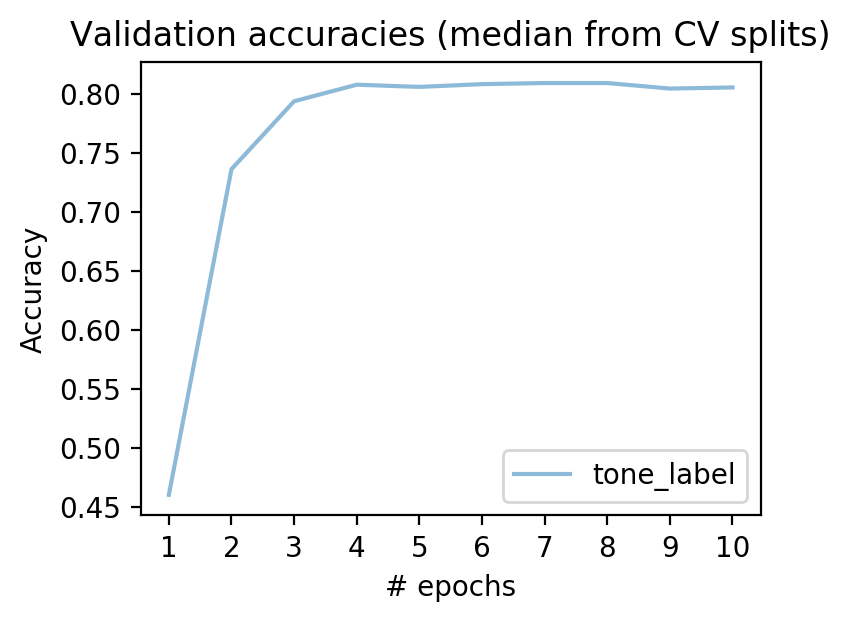

In [291]:
MODE = 'median'
# MODE = 'best'

ax = plt.figure(figsize=(4,3), dpi=200)
plt.title('Validation accuracies (' + MODE + ' from CV splits)')
plt.xlabel('# epochs')
plt.ylabel('Accuracy')
xrange = range(1, N_EPOCHS + 1)
plt.xticks(xrange, xrange)
for category in label_categories:
    if MODE == 'median':
        run_idx = performance[category].index(sorted(performance[category])[len(performance[category]) // 2])
    else:
        run_idx = performance[category].index(max(performance[category]))
    hist = callbacks[category][run_idx].history
    plt.plot(xrange, hist['val_acc'], label=category, alpha=.5)
plt.legend(loc='lower right')
plt.show()
ax.savefig('nn-cv-val-acc.png', format='png')

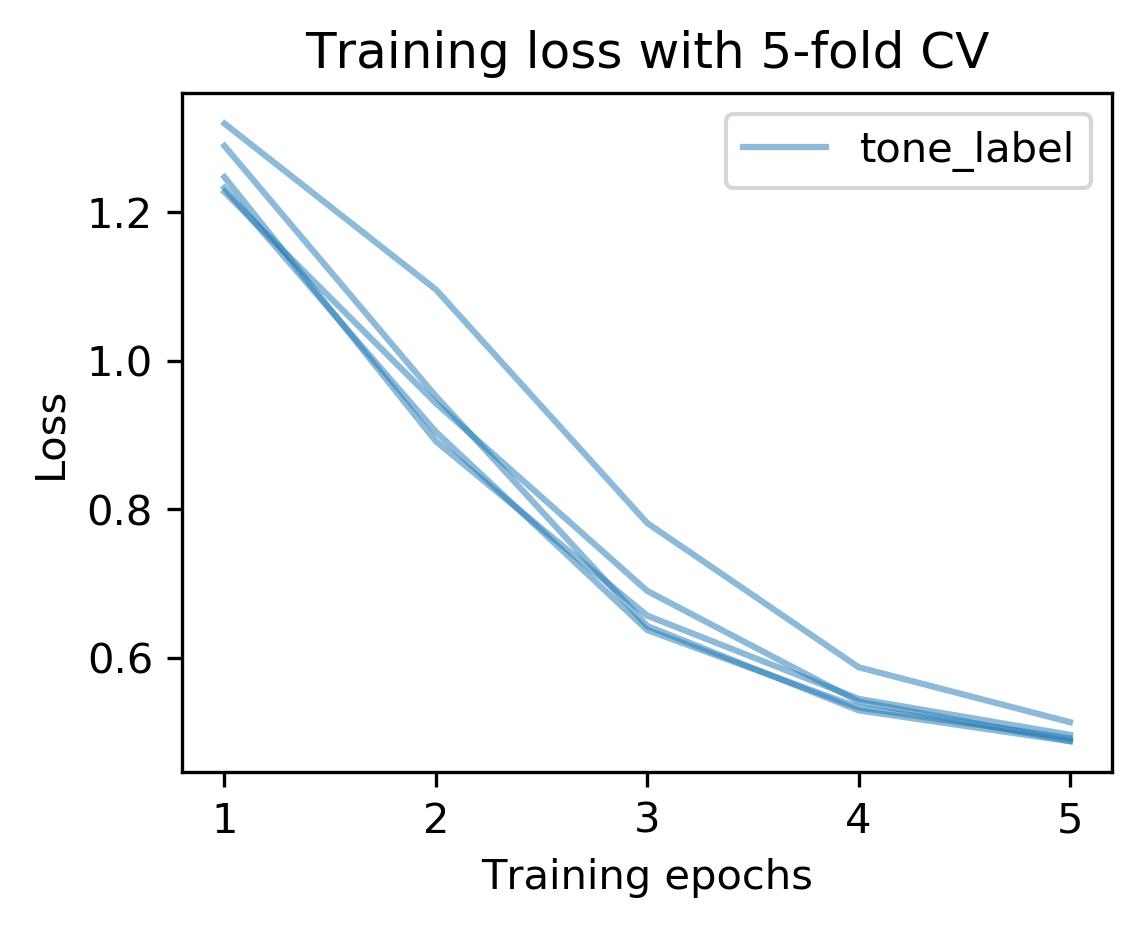

In [296]:
ax = plt.figure(figsize=(4,3), dpi=300)
plt.title('Training loss with 5-fold CV')
plt.xlabel('Training epochs')
plt.ylabel('Loss')
xrange = range(1, N_EPOCHS + 1 - 5)
plt.xticks(xrange, xrange)
for idx, category in enumerate(label_categories):
    for fold in range(N_FOLDS):
        val_acc = callbacks[category][fold].history['loss'][:-5]
        if not fold: 
            plt.plot(xrange, val_acc, label=category, color='C' + str(idx), alpha=.5)
        else:
            plt.plot(xrange, val_acc, label='__nolegend__', color='C' + str(idx), alpha=.5)
plt.legend()
# plt.tight_layout()
plt.show()
# ax.savefig('nn-cv-train-loss.eps', format='eps')

In [297]:
avg = 0
for cat in label_categories:
    best_idx = performance[cat].index(max(performance[cat]))
    print('{:16s}\t{:2.3f}%'.format(cat, 100 * test_performance[cat][best_idx]))
    avg += 100 * test_performance[cat][best_idx]
print("Average: " + str(avg / 4))

tone_label      	80.659%
Average: 20.164631465689563


In [298]:
test_performance

defaultdict(list,
            {'tone_label': [0.8022241596046411,
              0.810510249206503,
              0.8026602709860039,
              0.8065852586275826,
              0.8074574784009778]})

In [295]:
len(Y_complete[[x for x in Y_complete.columns if 'nucleus' in x]].columns)

62